# Author: Sevendi Eldrige Rifki Poluan

In [52]:
!nvidia-smi

Tue May 16 07:51:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:65:00.0 Off |                  N/A |
|  0%   44C    P8               38W / 390W|  23136MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!python3 -m pip install --upgrade pip
!pip install gym=0.26.2
!pip install pyvirtualdisplay 
!pip install pygame  

In [ ]:
!apt-get install -y xvfb ffmpeg

# Import the required libraries

In [2]:
import tensorflow as tf
import gym 
import numpy as np
from IPython.display import Image
import imageio 
from collections import deque
import random
import matplotlib.pyplot as plt

2023-05-16 04:41:07.889818: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 04:41:07.927081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gym.__version__

'0.26.2'

# Here is how it looks like before training (baseline)

In [55]:
# create the environment for the MountainCar task
env = gym.make("MountainCar-v0", render_mode='rgb_array') 

# resetting the environment to its initial state and obtaining the first observation/state
observation, _ = env.reset()
 
frames = [] 
terminated = False

# run the environment and record the freames (gif)
for x in range(100):
    
    # capture the frame
    frame = env.render()
    
    # store the frames
    frames.append(frame)
    
    # get the next state 
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())  

env.close()

In [56]:
# save the frames as GIF
imageio.mimsave("Render/demo.gif", frames, duration=0.1)

In the MountainCar-v0 environment, the goal is to get a car to the top of a hill by driving up a steep slope. The car is underpowered and cannot reach the top of the hill by simply driving straight up, so the agent must learn to use momentum to climb the hill.

   The episode in MountainCar-v0 is considered finished when either of the following conditions is met:

    - The car reaches the top of the hill and its position is greater than or equal to 0.5.

    - The episode reaches 200 time steps.

At each time step, the agent receives a reward of -1, and the goal is to minimize the number of time steps required to reach the top of the hill. If the agent is able to reach the top of the hill before the episode ends, it receives a larger positive reward.

In the MountainCar environment, the observation is a one-dimensional array with two elements. The first element (index 0) corresponds to the position of the car, and the second element (index 1) corresponds to the velocity of the car. 

There are three possible actions available to the agent: push left (action 0), no push (action 1), and push right (action 2).

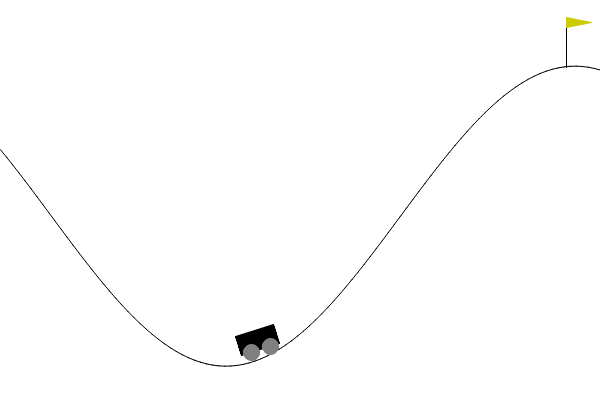

In [57]:
Image(filename="Render/demo.gif")

# Create the agent

In [20]:
# allows for the same random events or processes to occur each time the code is run
seed = 20220
tf.random.set_seed(seed)
np.random.seed(seed)

In [33]:
class DQReinforcementLearning:
    
    def __init__(self, 
                 state_size, 
                 action_size,
                 batch_size = 128, # in this case lower batch size may lead to overfitting because it makes the model more sensitive to individual data points in the training set
                 gamma=0.99,
                 epsilon = 1.0,
                 epsilon_decay = 0.9999,
                 epsilon_min = 0.01,
                 memory_size=2000,
                 start_training_after_memory_reach = 1000,
                 load_weights=False
        ):
  
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
         
        self.gamma = gamma # discount factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min 
        self.memory = deque(maxlen=memory_size) # store the experience of the agent (replay buffer) - limit the size of the replay buffer and remove the oldest transitions once it reaches its maximum size. 
        self.start_training_after_memory_reach = start_training_after_memory_reach # ensure that the agent has collected enough experience before starting to train the neural network
         
        self.model = self.create_model() # create a neural network for reinforcement learning
        self.target_model = self.create_model() # i use a separate network to generate the target Q-values during training, rather than using the same network that is being updated. This can help stabilize the learning process by fixing the target values during each update.
        
        # load model if any saved weights available
        try:
            if load_weights:
                self.model.load_weights("Saved model/model.weights.h5")
                self.update_target_model()
                print("Weights loaded ...")
        except Exception as e:
            print("Failed load weights", e)
          
    def create_model(self):
        inputs = tf.keras.layers.Input(shape=(self.state_size))   
        x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='RandomNormal')(inputs)
        x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='RandomNormal')(x) 
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='RandomNormal')(x) 
        
        # i used a linear activation function to allow for a wider range of possible outputs since the Q-values can be negative or positive
        outputs = tf.keras.layers.Dense(self.action_size, activation="linear")(x)

        model = tf.keras.Model(inputs, outputs) 
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)) 
        
        return model 
 
    def train(self):
        
        # waiting until the agent has enough experience in the replay buffer before starting training
        if len(self.memory) < self.start_training_after_memory_reach:
            return
        
        # sample a batch randomly from the agent's experience and use it for training.
        batch = random.sample(self.memory, self.batch_size) 
        
        # squeeze the additional dimension from our input data. 
        x_input = np.vstack(np.array(batch, dtype=object)[:, 0])
        x_target = np.vstack(np.array(batch, dtype=object)[:, 3])

        action = np.array(batch, dtype=object)[:, 1]
        reward = np.array(batch, dtype=object)[:, 2]
        done = np.array(batch, dtype=object)[:, 4]
        
        target = self.model.predict(x_input, verbose=0)
        target_val = self.target_model.predict(x_target, verbose=0) # to overcome the instability issue in deep Q-learning

        for i in range(self.batch_size):
            
            # if the termination status is true, assign a low reward to the corresponding action in our Q-table in the network
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Bellman equation
                # Q(s, a) = r + γ(max(Q(s', a')))
                target[i][action[i]] = reward[i] + self.gamma * (max(target_val[i]))

        history = self.model.fit(
            x_input, 
            target, 
            epochs=1,  
            verbose=0
        )
        return history
    
    def save(self): 
        self.model.save_weights("Saved model/model.weights.h5")
        
    def get_policy(self, state, random_action=False):
        if np.random.rand() <= self.epsilon and random_action:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(tf.expand_dims(state, axis=0), verbose=0)
            return q_value.argmax()
 
    def add_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 
            
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def reward_function(self, env, observation, action):
        position, velocity = observation
        if position >= env.observation_space.high[0] - 0.1:
            reward = 100  # positive reward for reaching the flag
        else:
            reward = -0.1 * abs(action)  # negative reward for taking actions (encourages the agent to take fewer actions)
            reward += max(0.0, env.observation_space.high[0] - abs(position))  # intermediate reward for making progress towards the flag
        return reward

# Train the agent

In [22]:
# create the environment for MountainCar
env = gym.make('MountainCar-v0')

# obtain the number of states available and actions for building the neural network in the MountainCar environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# create an agent instance for the MountainCar
agent = DQReinforcementLearning(state_size, action_size, load_weights=False)
agent.model.summary()
 
EPISODES = 1000
max_step_per_episode = 500
rewards = []
losses = []
max_rewards = 0
count_terminated = 0

for episode in range(EPISODES):
    
    # reset the state for every episode
    total_reward_per_episode = 0
    observation, _ = env.reset() 
    terminated = False 
    count_step = 0 
    while not terminated:  
         
        action = agent.get_policy(observation) 
        next_observation, reward, terminated, truncated, info = env.step(action) 
        
        # I developed a custom reward function because using the default reward from the engine, 
        # which only gives -1 except when the car reaches the flag, didn't make sense to me. 
        # I wanted to provide rewards for the car's efforts in getting closer to the flag, 
        # even if it doesn't reach it. Using the default engine's reward of -1 for everything 
        # would have made the training process too time-consuming.
        reward = agent.reward_function(env, next_observation, action)
        
        # add experience to the agent
        agent.add_experience(observation, action, reward, next_observation, terminated)
         
        # train the agent's model
        history = agent.train()
        loss = history.history["loss"][0] if history is not None else float("inf")
        losses.append(loss)
        
        # collect the total rewards obtained
        total_reward_per_episode += reward
        
        # update the state for the next prediction
        observation = next_observation.copy()
        
        # this prevents the need to wait for an entire episode to finish, which can be time-consuming.
        if count_step == max_step_per_episode - 1:
            terminated = True
 
        # if the terminated status is true, it means that the episode has ended and the agent needs to start a new episode from the initial state
        if terminated:
             
            # collect the total rewards obtained
            rewards.append(total_reward_per_episode)  
            
            # i used this to prevent from the instability issue in deep Q-learning
            # because the Q-values and target values used to train the network are constantly changing as the network learns, which makes the environment non-stationary
            agent.update_target_model()
            
            print(f"EPISODE: {episode} REWARD: {total_reward_per_episode} MEMORY_USED: {len(agent.memory)} EPSILON: {agent.epsilon} LOSS: {loss}")
            
            terminated = True
        
        count_step += 1
    
    # saves the model weights whenever the number of rewards exceeds a certain threshold (max_rewards | total_reward_per_episode)
    if (max_rewards < total_reward_per_episode) and len(agent.memory) > agent.start_training_after_memory_reach:
        agent.save()
        print("-------------------------------------------- model improved: saved to model.weights.h5")
        
        max_rewards = max(max_rewards, total_reward_per_episode)
    
    # maintain to close all episodes when the last 7 rewards reach 100 rewards 
    if total_reward_per_episode >= 100: 
        count_terminated +=1
    else: 
        count_terminated = 0
    if count_terminated == 7:
        agent.save()
        print("-------------------------------------------- model improved: saved to model.weights.h5")
        break
    
 

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_40 (Dense)            (None, 64)                192       
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dense_42 (Dense)            (None, 256)               33024     
                                                                 
 dense_43 (Dense)            (None, 3)                 771       
                                                                 
Total params: 42,307
Trainable params: 42,307
Non-trainable params: 0
_________________________________________________________________
EPISODE: 0 REWARD: -7.230185437202445 MEMORY_USED: 500

# Plot the rewards and loss during training

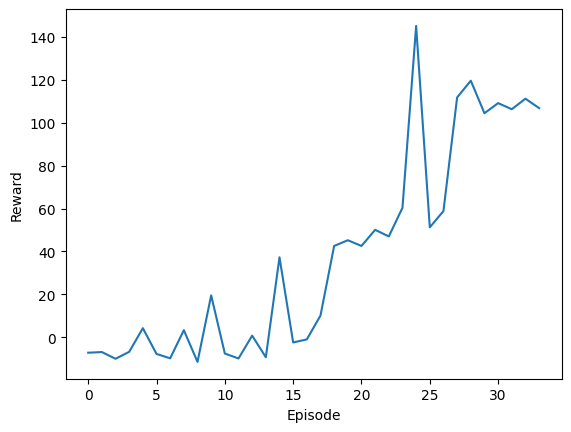

In [23]:
plt.figure()
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

It's great to see that the reward is consistently increasing over time. This indicates that the model is learning and making progress in its understanding and decision-making. It's a positive sign that the model is improving its performance through learning from the rewards it receives.

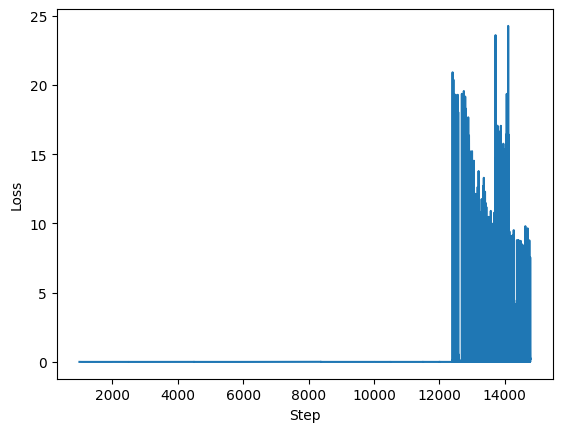

In [24]:
plt.figure()
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

It appears that the loss is increasing because we regularly update the rewards in our formulated Q-table. However, despite the increasing loss, the network is continuously learning and improving its performance.

# Load the model

In [49]:
# create the environment for MountainCar
env = gym.make('MountainCar-v0', render_mode="rgb_array")

# obtain the number of states available and actions for building the neural network in the MountainCar environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# create an agent instance for the MountainCar
agent = DQReinforcementLearning(state_size, action_size, load_weights=True)

Weights loaded ...


# Evaluate the trained model

In [50]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")
# reset the environment and get the initial state
observation, _ = env.reset()
terminated = False

# store the frames
frames = []
count = 0

# run the environment 
while not terminated:
    
    # render the environment and capture the frame
    frame = env.render()
    
    # store the frames
    frames.append(frame)
    
    action = agent.target_model.predict(tf.expand_dims(observation, axis=0), verbose=0).argmax()
    # action = agent.get_policy(observation, random_action=False)
     
    # get the next state
    observation, reward, terminated, truncated, info = env.step(action) 
    
    if count == 400:
        terminated = True
    
    count += 1

env.close()

# save the frames as a GIF
imageio.mimsave("eval.gif", frames, duration=0.1)

# Evaluate with the model that is already trained

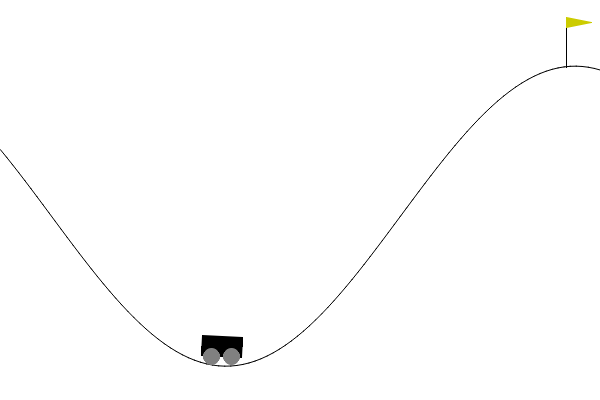

In [51]:
Image(filename="eval.gif")